## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from copy import deepcopy
from datetime import datetime, timedelta
from dateutil.relativedelta import *

import cvxpy as cvx
from pypfopt import EfficientFrontier, risk_models, expected_returns

%matplotlib inline

## Basic Analysis and Visualisation of Crypto

In [3]:
def get_returns_for_multiple_crypto(tickers, start_date, end_date):
    # initialise output dataframe
    returns_df = pd.DataFrame()
    
    for ticker in tickers:
        # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
        format='%Y-%m-%d'
        s = yf.download(ticker, datetime.strptime(start_date, format), datetime.strptime(end_date, format))
        # calculate log returns
        s['Log Returns'] = np.log(s['Adj Close']/s['Adj Close'].shift(1))
        # append to returns_df
        returns_df[ticker] = s['Log Returns']
        
    # skip first row as it will be NA
    # and fill other NA values by 0 in case there are days with no trades
    returns_df = returns_df.iloc[1:].fillna(0)
        
    return returns_df

In [4]:
crypto = ['BTC-USD', 'ETH-USD', 'DOGE-USD', 'MATIC-USD']

returns_df = get_returns_for_multiple_crypto(crypto, start_date = '2020-02-01', end_date = '2022-02-01')
returns_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,BTC-USD,ETH-USD,DOGE-USD,MATIC-USD
Date,,,,
2020-02-02,-0.005178,0.026559,0.018814,0.041880
2020-02-03,-0.005456,0.006592,-0.011410,0.144471
2020-02-04,-0.012185,-0.003242,0.025492,-0.044297
2020-02-05,0.046028,0.076176,0.031074,0.014285
2020-02-06,0.012033,0.038936,0.027127,0.132067


Text(0.5, 1.0, 'Crypto Correlations')

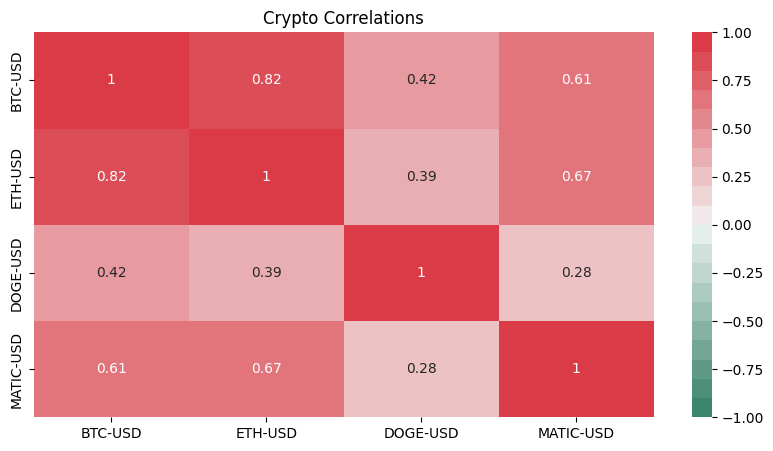

In [5]:
# Plot heatmap of the crypto correlations 
plt.figure(figsize=(10, 5))
sns.heatmap(round(returns_df.corr(), 2), cmap=sns.diverging_palette(160, 10, n = 20), annot=True, vmin=-1, vmax=1)
plt.title("Crypto Correlations")

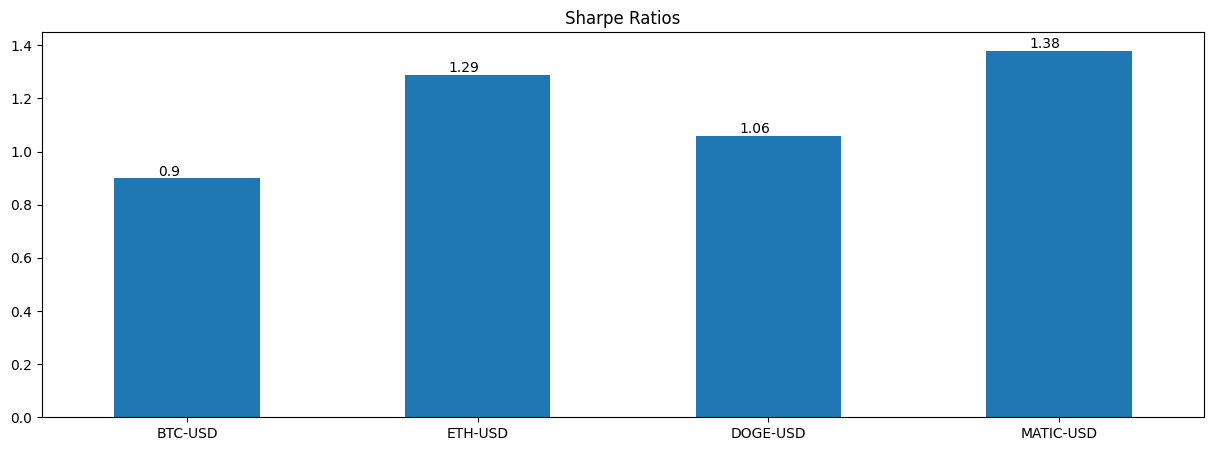

In [6]:
# Calculate sharpe ratio and annualise by multiply with sqrt(365)
# 365 tradings days since crypto is traded throughout the year
ax = round(returns_df.mean(axis = 0) / returns_df.std(axis = 0) * 365 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))

# Set x-axis labels to horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# Plot Sharpe Ratio
plt.title("Sharpe Ratios")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

**Observations:**

The selected cryptos are all positively correlated:
- BTC & ETH have a very high correlation coefficient of 0.82    
- MATIC is also highly correlated with BTC & ETH at 0.61 & 0.67 respectively 
- DODGE is less correlated with the other 3, with coefficient between 0.28 and 0.42
Therefore it may be difficult to diversify portfolio and reduce risk by simply buying different types of cryptos as they are all positively correlated.

All cryptos have sharpe ratio >=0.9. Generally, they all offer good reward to risk ratio as the Shape ratio lies around 1. The higher the Sharpe ratio, the higher the risk to reward ratio. MATIC has the highest sharpe ratio of 1.38.
    

## Markowitz MVO and Simulated Portfolio Value

In [7]:
# Get more historical data
hist_returns_df = get_returns_for_multiple_crypto(crypto, start_date = '2019-02-01', end_date = '2020-2-2')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [8]:
def get_optimized_portfolio(returns_df, returns_scale = .0001, max_holding = 0.5):
    """
    Function that takes in the returns series of assets, minimizes the utility function, 
    and returns the portfolio weights
    
    Parameters
    ----------
    returns_df : pd.dataframe
        Dataframe containing log asset return series in each column
    
    returns_scale : float
        The scaling factor applied to the returns
        
    max_holding : float
        The maximum weight a stock can hold.
        
    Returns
    -------
    x : np.ndarray
        A numpy ndarray containing the weights of the assets in the optimized portfolio
    """
    # convert returns dataframe to numpy array
    returns = returns_df.T.to_numpy()
    
    # m is the number of assets
    m = returns.shape[0]
  
    # covariance matrix of returns
    cov = np.cov(returns)
    
    # creating variable of weights to optimize
    x = cvx.Variable(m)
    
    # portfolio variance, in quadratic form
    portfolio_variance = cvx.quad_form(x, cov)

    log_returns_df = np.log(returns_df+1)
    total_return_log = log_returns_df.sum().to_numpy()
    
    total_simple_return = np.exp(total_return_log) -1

    frequency = 365 #assume daily compounding, we are going to take geometric average
    #this is the standard basic mean for optimization (to assume daily compounding)
    
    horizon_length = returns.shape[1]
    expected_mean = (1 + total_simple_return) ** (1 / horizon_length) - 1

    # assume element wise multiplication, followed up by sum of weights
    portfolio_return = sum(cvx.multiply(expected_mean, x))
    
    # Objective Function
    # We want to minimize variance and maximize returns. We can also minimize the negative of returns.
    # Therefore, variance has to be a positive and returns have to be a negative.
    objective = cvx.Minimize(portfolio_variance - returns_scale * portfolio_return)
    
    # Constraints
    # long only, sum of weights equal to 1, no allocation to a single stock great than 50% of portfolio
    constraints = [x >= 0, sum(x) == 1, x <= max_holding]

    # use cvxpy to solve the objective
    problem = cvx.Problem(objective, constraints)
    
    # retrieve the weights of the optimized portfolio
    result = problem.solve()
    
    return x.value

In [9]:
temp = pd.concat([hist_returns_df,returns_df], ignore_index=False, axis=0)
temp.reset_index(inplace=True)

# Convert date column to datetime format
temp['Date'] = pd.to_datetime(temp['Date'])

# Convert log to simple returns
temp.iloc[:, 1:] = np.exp(temp.iloc[:, 1:]) - 1

Text(0.5, 1.0, 'Porfolio Optimisation Holding Weights with Constraint')

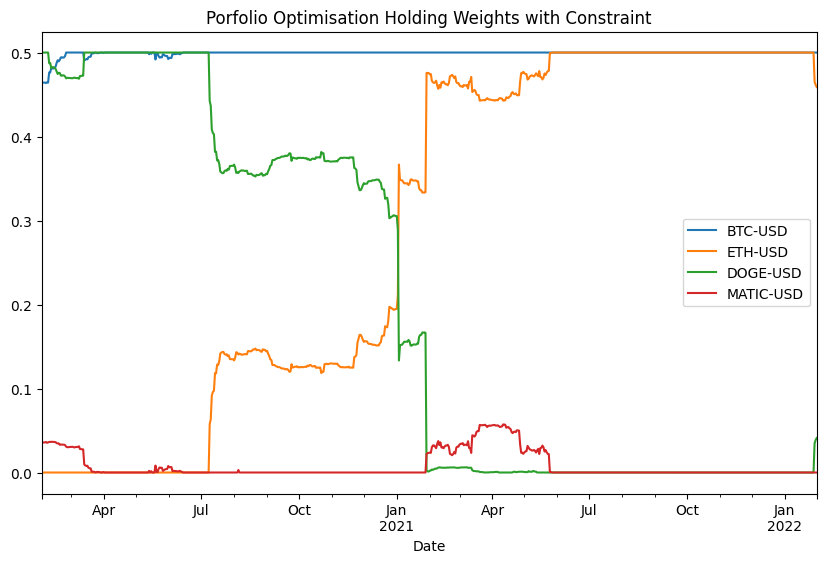

In [10]:
# Get optimal portfolio weights
optimal_weights_df = pd.DataFrame(columns = temp.columns)

for i in range(365,365 + 730):
    optimized_portfolio = get_optimized_portfolio(temp.iloc[i- 365:i,1:], returns_scale = 0, max_holding=0.5)
    weight = pd.Series(optimized_portfolio, index = temp.columns[1:])
    weight = pd.concat([pd.Series([temp.iloc[i,0]], index = ['Date']), weight])
    optimal_weights_df = pd.concat([optimal_weights_df,weight.to_frame().T],ignore_index=False)

optimal_weights_df['Date'] = pd.to_datetime(optimal_weights_df['Date'], utc=False)

optimal_weights_df.plot('Date',returns_df.columns,figsize=(10,6))
plt.title('Porfolio Optimisation Holding Weights with Constraint')

Text(0.5, 1.0, 'Porfolio Optimisation Holding Weights without Constraint')

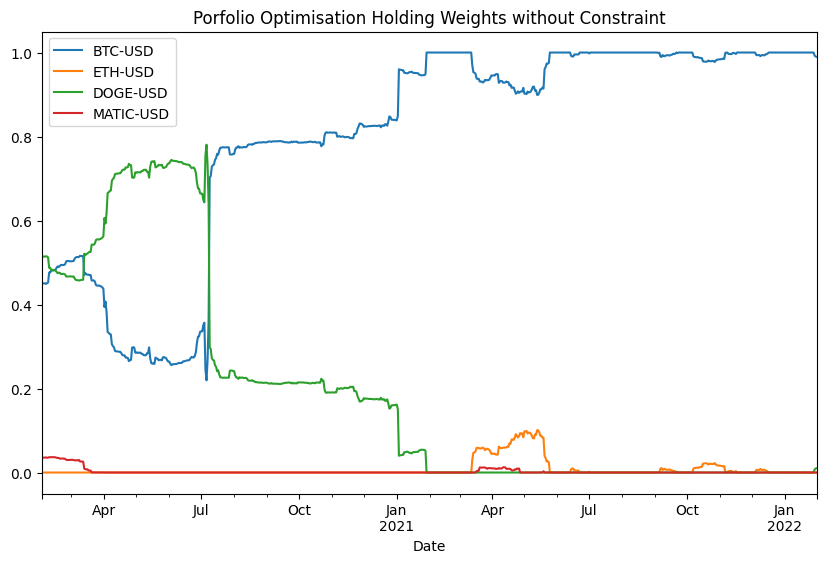

In [11]:
optimal_weights_df2 = pd.DataFrame(columns = temp.columns)

for i in range(365,365 + 730):
    optimized_portfolio2 = get_optimized_portfolio(temp.iloc[i-365:i,1:], returns_scale = 0, max_holding=1)
    weight2 = pd.Series(optimized_portfolio2, index = temp.columns[1:])
    weight2 = pd.concat([pd.Series([temp.iloc[i,0]], index = ['Date']), weight2])
    optimal_weights_df2 = pd.concat([optimal_weights_df2,weight2.to_frame().T],ignore_index=False)

optimal_weights_df2['Date'] = pd.to_datetime(optimal_weights_df2['Date'], utc=False)

optimal_weights_df2.plot('Date',returns_df.columns,figsize=(10,6))
plt.title('Porfolio Optimisation Holding Weights without Constraint')

In [12]:
def compute_annualised_portfolio_returns(log_returns, weights):
    weighted_returns = (np.exp(log_returns) - 1) * weights
    portfolio_returns = np.sum(weighted_returns, axis=1)
    return portfolio_returns

In [13]:
def compute_log_portfolio_returns(log_returns, weights):
    weighted_returns = (np.exp(log_returns) - 1) * weights
    portfolio_returns = np.sum(weighted_returns, axis=1)
    log_returns = np.log(portfolio_returns.astype('float64') + 1)
    return log_returns

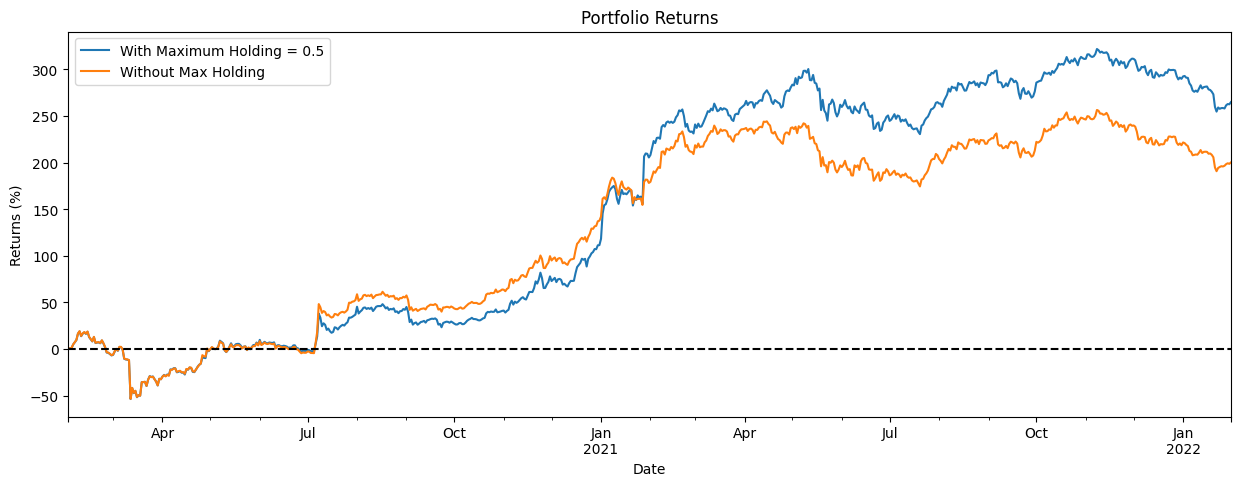

In [14]:
# Compute log returns for the two cases
portfolio_1 = compute_log_portfolio_returns(returns_df, optimal_weights_df.iloc[:,1:].to_numpy())
portfolio_2 = compute_log_portfolio_returns(returns_df, optimal_weights_df2.iloc[:,1:].to_numpy())

all_portfolio_returns = pd.concat([portfolio_1, portfolio_2], axis = 1)
all_portfolio_returns.columns = ["With Maximum Holding = 0.5", "Without Max Holding"]

# Plot log returns
all_portfolio_returns.expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (15, 5))
plt.title("Portfolio Returns")
plt.ylabel("Returns (%)")
plt.axhline(y=0, color='black', linestyle='--')

In [15]:
# Compute annualised log returns
portfolio_1_annualised_log_return = sum(portfolio_1)/2
portfolio_2_annualised_log_return = sum(portfolio_2)/2

# Copmute annualised simplre retruns
portfolio_1_annualised_simple_return = np.exp(portfolio_1_annualised_log_return) - 1
portfolio_2_annualised_simple_return = np.exp(portfolio_2_annualised_log_return) - 1

In [16]:
portfolio_data = {"Portfolio with maximum holding weight": 
                  {"Annualised log return":portfolio_1_annualised_log_return, 
                   "Annualised simple return": portfolio_1_annualised_simple_return,
                   "Annualised std":portfolio_1.std()}, 
                  "Portfolio without maximum holding weight": 
                   {"Annualised log return":portfolio_2_annualised_log_return, 
                    "Annualised simple return":portfolio_2_annualised_simple_return, 
                    "Annualised std":portfolio_2.std()}}

portfolio_data = pd.DataFrame(portfolio_data)
portfolio_data

,Portfolio with maximum holding weight,Portfolio without maximum holding weight
Annualised log return,1.324204,1.000783
Annualised simple return,2.759190,1.720410
Annualised std,0.048501,0.043015


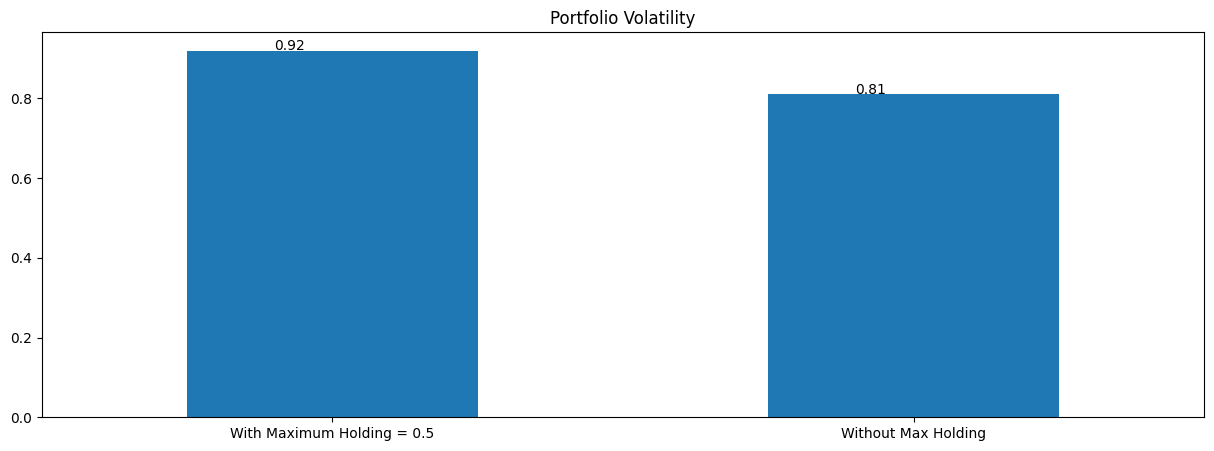

In [17]:
# Compute annualised volatility
ax = round(all_portfolio_returns.std(axis = 0) * 356 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))

# Set x-axis labels to horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# Plot volatility
plt.title("Portfolio Volatility")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.001))

**Results**

The annualised log return for the portfolio with maximum holding weights of 0.5 (=1.32) is greater than that for the portfolio with no constraints (=1.00).

The annuazlied volatility for the two portfolios are 0.92 and 0.81 respectively.

The portfolio with maximum holding weights of 0.5 portfolio has both higher return and volatility.

## Calculate VaR(5%) for Component Assets

In [18]:
def calc_historical_VaR(log_returns, alpha):
    log_var = log_returns.quantile(alpha)
    var = np.exp(log_var) - 1
    return -var

def calc_historical_ES(log_returns, alpha):
    log_var = log_returns.quantile(alpha)
    log_es = sum(log_returns[log_returns < log_var]) / (alpha * len(log_returns))
    percentage_es = np.exp(log_es) - 1
    return -percentage_es

def plot_VaR_and_ES(log_returns, alpha, ticker):
    VaR = log_returns[ticker].rolling(365).apply(lambda x: calc_historical_VaR(x, alpha))
    ES = log_returns[ticker].rolling(365).apply(lambda x: calc_historical_ES(x, alpha))
    
    plot_df = pd.concat(([VaR, ES]), axis = 1)
    plot_df.columns = ["VaR", "ES"]

    plot_df.loc[(plot_df.index >= '2021-02-01') & (plot_df.index <= '2022-02-01')].plot(figsize = (15, 5))
    plt.title(f"{ticker} VaR and ES")
    plt.ylabel("VaR and ES")
    plt.axhline(y=0, color='black', linestyle='--')
    plt.legend(loc="lower right")

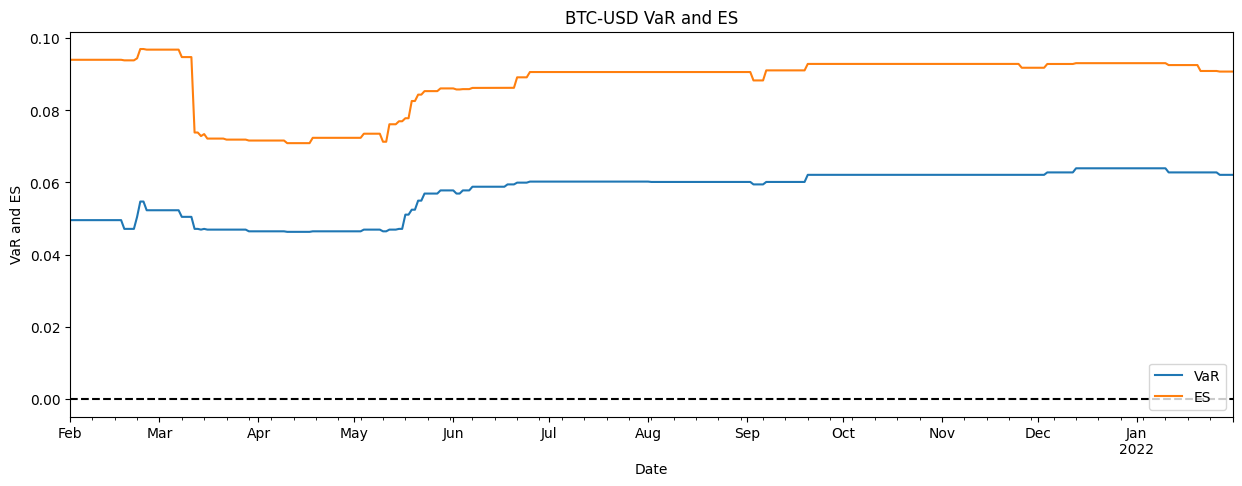

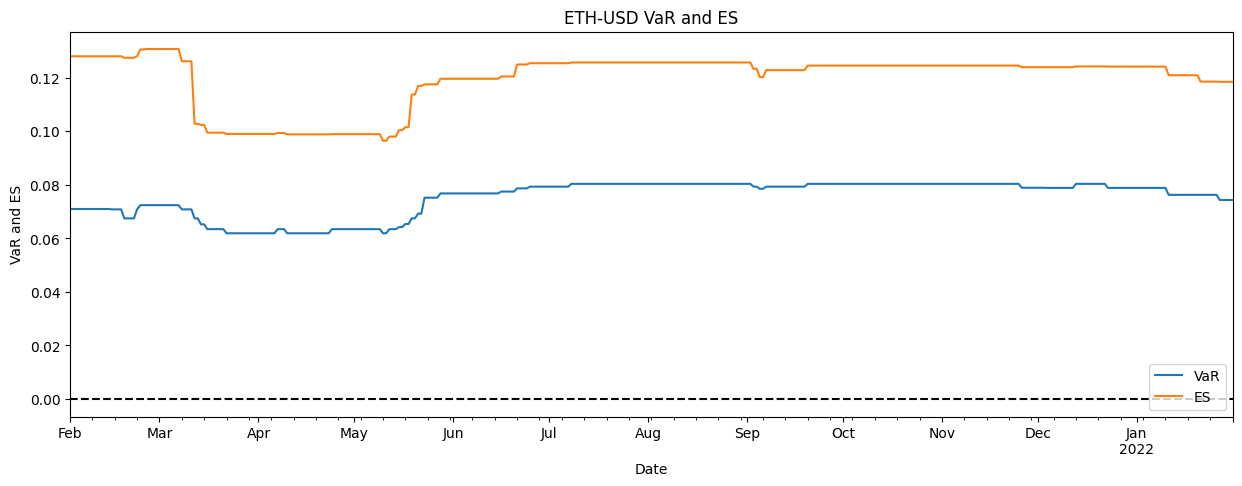

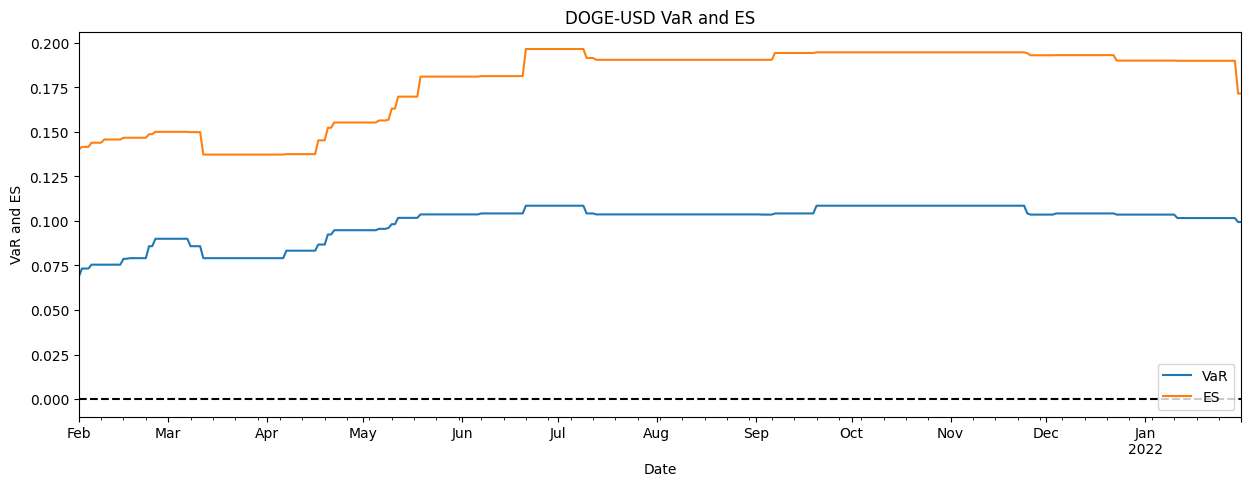

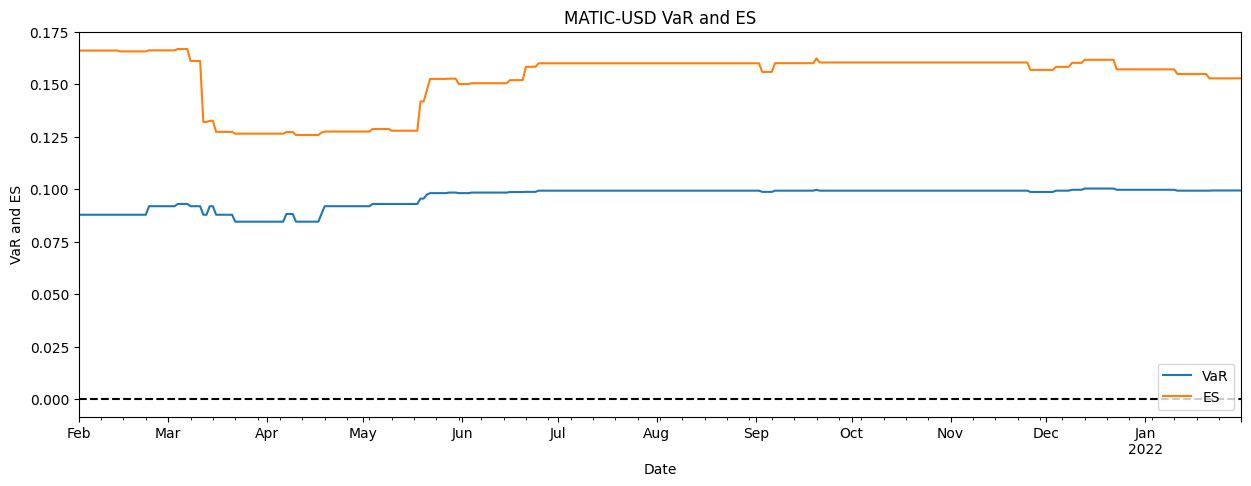

In [19]:
for ticker in crypto:
    plot_VaR_and_ES(returns_df, 0.05, ticker)

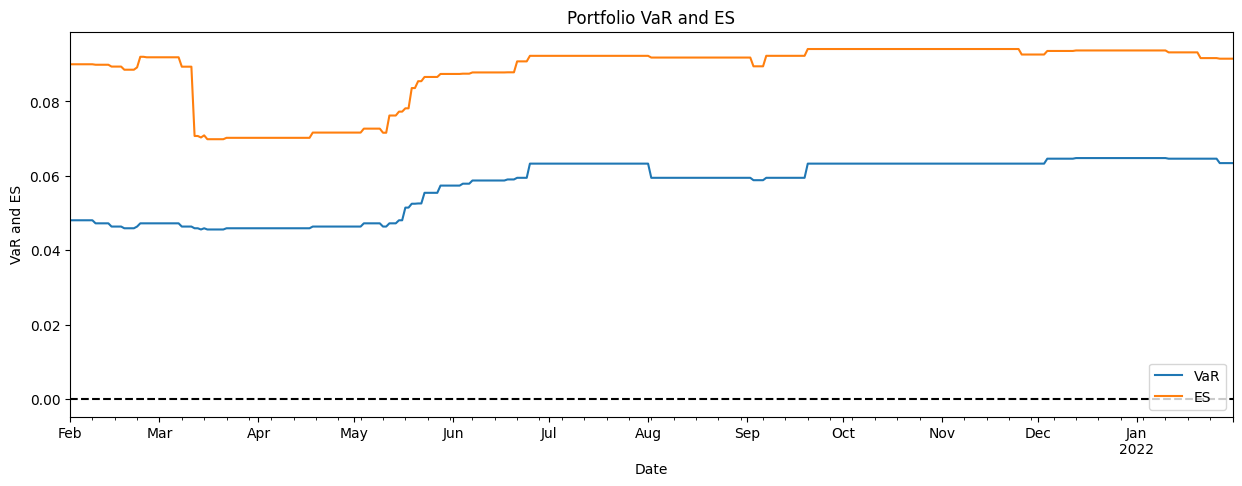

In [20]:
portfolio_VaR = portfolio_2.rolling(365).apply(lambda x: calc_historical_VaR(x, 0.05))
portfolio_ES = portfolio_2.rolling(365).apply(lambda x: calc_historical_ES(x, 0.05))

portfolio_plot_df = pd.concat(([portfolio_VaR, portfolio_ES]), axis = 1)
portfolio_plot_df.columns = ["VaR", "ES"]

portfolio_plot_df.loc[(portfolio_plot_df.index >= '2021-02-01') & (portfolio_plot_df.index <= '2022-02-01')].plot(figsize = (15, 5))
plt.title("Portfolio VaR and ES")
plt.ylabel("VaR and ES")
plt.axhline(y=0, color='black', linestyle='--')
plt.legend(loc="lower right")

In [21]:
crypto_VaR_and_ES_data = {}
for ticker in crypto:
    temp = {'Mean_VaR': np.mean(returns_df[ticker].rolling(365).apply(lambda x: calc_historical_VaR(x, 0.05))), 
            'Mean_ES': np.mean(returns_df[ticker].rolling(365).apply(lambda x: calc_historical_ES(x, 0.05)))}
    crypto_VaR_and_ES_data[ticker] = temp 

crypto_VaR_and_ES_data = pd.DataFrame(crypto_VaR_and_ES_data)
crypto_VaR_and_ES_data

,BTC-USD,ETH-USD,DOGE-USD,MATIC-USD
Mean_VaR,0.057272,0.075121,0.099288,0.096175
Mean_ES,0.087984,0.119480,0.178078,0.153100


**Observation**

DOGE-USD is the riskiest component asset. 

It has the highest mean Expected Shortfall (ES) and ValueAtRisk (VaR). Although MATIC's VaR is of a similar level, DOGE still has a higher ES.

## Hedge by Options

In [22]:
def get_prices_for_multiple_cryptos(tickers, start_date, end_date):
    '''
    Function that uses Pandas DataReader to download data directly from Yahoo Finance,
    computes the Prices series for each ticker, and returns a DataFrame 
    containing the Prices of all specified tickers.
    
    Parameters:
    - tickers (list): List of Crypto Tickers.
    - start_date, end_date (str): Start and end dates in the format 'YYYY-MM-DD'.
    
    Returns:
    - prices_df (pd.DataFrame): A DataFrame with dates as indexes, and columns corresponding
                                 to the prices series of each ticker.
    '''
    prices_df = pd.DataFrame()

    for ticker in tickers:
        format='%Y-%m-%d'
        s = yf.download(ticker, datetime.strptime(start_date, format), datetime.strptime(end_date, format))
        prices_df[ticker] = s['Adj Close']
        
    return prices_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


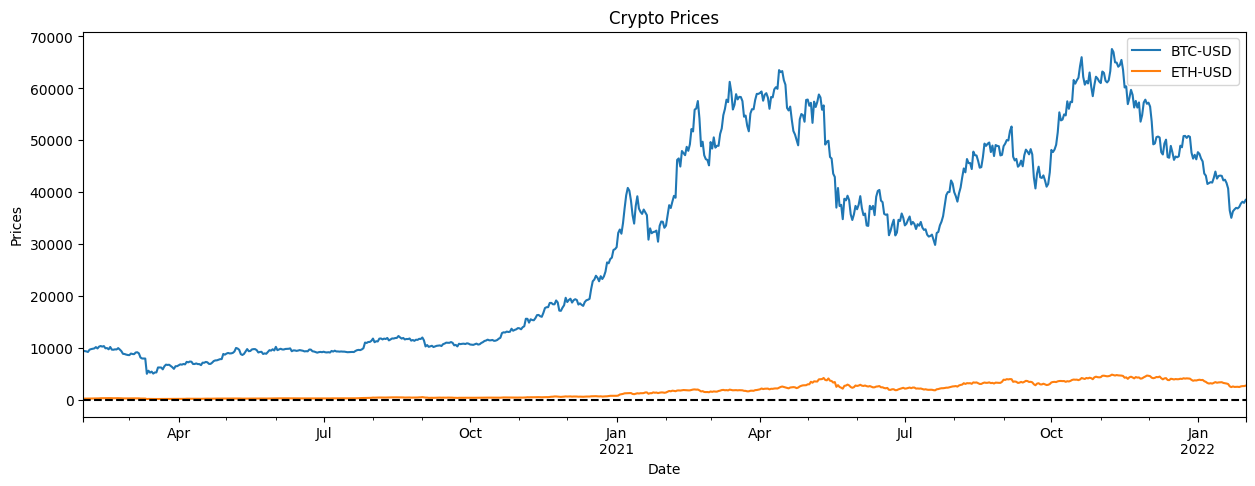

In [23]:
prices = get_prices_for_multiple_cryptos(['BTC-USD', 'ETH-USD'], start_date = '2020-02-01', end_date = '2022-02-01')

prices.loc[prices.index].plot(figsize = (15, 5))
plt.title("Crypto Prices")
plt.ylabel("Prices")
plt.axhline(y=0, color='black', linestyle='--')

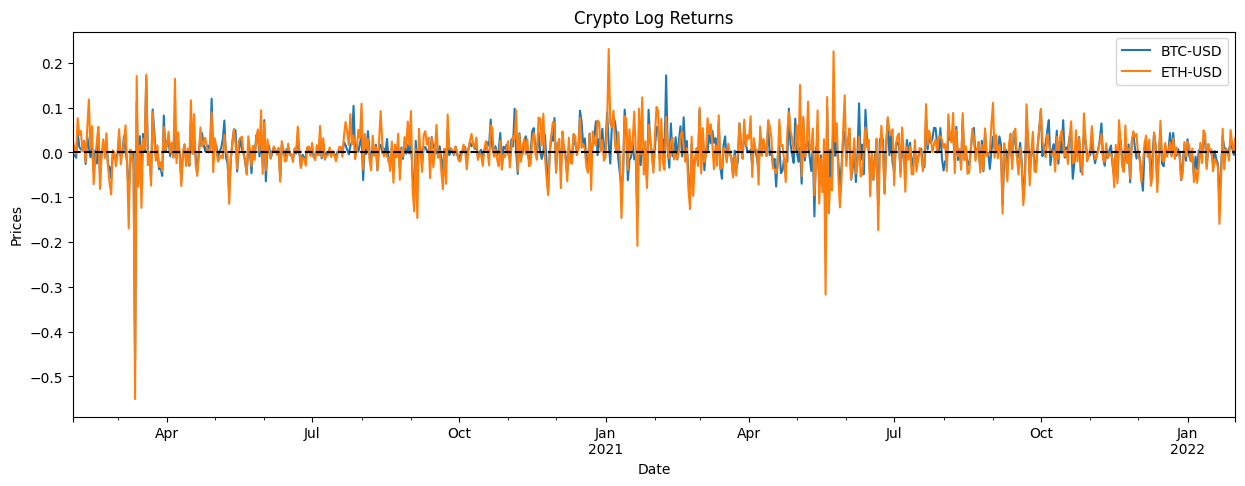

In [24]:
returns_df[['BTC-USD', 'ETH-USD']].plot(figsize = (15, 5))
plt.title("Crypto Log Returns")
plt.ylabel("Prices")
plt.axhline(y=0, color='black', linestyle='--')

                      BTC-USD   ETH-USD
Volatility           0.041091  0.054553
Upside Volatility    0.026488  0.033455
Downside Volatility  0.035376  0.046709


(array([0, 1, 2]),
 [Text(0, 0, 'Volatility'),
  Text(1, 0, 'Upside Volatility'),
  Text(2, 0, 'Downside Volatility')])

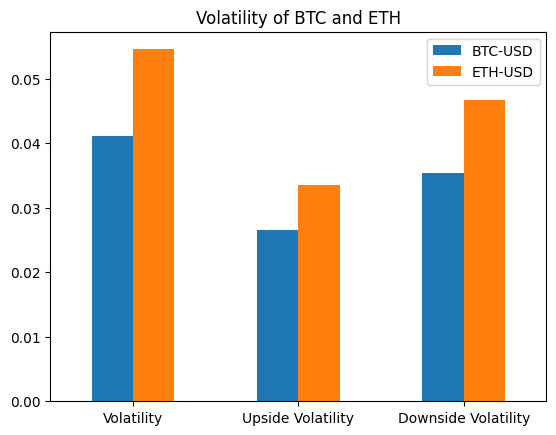

In [25]:
std = returns_df[['BTC-USD', 'ETH-USD']].std(ddof=0)
up_std = returns_df[['BTC-USD', 'ETH-USD']][returns_df[['BTC-USD', 'ETH-USD']] > 0].std(ddof=0)
down_std = returns_df[['BTC-USD', 'ETH-USD']][returns_df[['BTC-USD', 'ETH-USD']] < 0].std(ddof=0)

# Combine Series into a DataFrame
std_data = pd.DataFrame({
    'Volatility': std,
    'Upside Volatility': up_std,
    'Downside Volatility': down_std
})
std_data = std_data.T
print(std_data)

std_data.plot.bar(title='Volatility of BTC and ETH')
plt.xticks(rotation=0)

In [26]:
option_df = pd.read_csv('OKEx_options_trade.csv', skiprows = 1)

# Convert timestamp to datetime format
option_df.loc[:,'transaction_datetime'] = (option_df['timestamp'].str[0:10] + " "+ option_df['timestamp'].str[11:19])
option_df.loc[:,'transaction_datetime'] = pd.to_datetime(option_df['transaction_datetime'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# Sort from later to earlier transaction date 
option_df = option_df.sort_values(['transaction_datetime'], ascending=False)

# Keep entries with valid data
option_df = option_df[option_df.price != 'price']

# Parse intrument_id into asset, expiry date, strike price and option type
option_df.loc[:,'asset'] = (option_df['instrument_id'].str[0:7])
option_df.loc[:,'expiry_date'] = (option_df['instrument_id'].str[8:14])
option_df.loc[:,'expiry_date'] = pd.to_datetime(option_df['expiry_date'], errors='coerce', format='%y%m%d')
option_df.loc[:,'strike_price'] = pd.to_numeric(option_df['instrument_id'].str[15:-2])
option_df.loc[:,'option_type'] = (option_df['instrument_id'].str[-1])

option_df.head()

,0,side,trade_id,price,qty,instrument_id,timestamp,transaction_datetime,asset,expiry_date,strike_price,option_type
100627,30851,sell,10,0.057,1,BTC-USD-211231-62000-C,2021-12-01T23:59:42.291Z,2021-12-01 23:59:42,BTC-USD,2021-12-31 00:00:00,62000,C
100626,30850,sell,1,0.0015,1,BTC-USD-211202-56000-P,2021-12-01T23:59:31.243Z,2021-12-01 23:59:31,BTC-USD,2021-12-02 00:00:00,56000,P
100625,30849,buy,19,0.0205,6,ETH-USD-211203-4600-C,2021-12-01T23:58:48.285Z,2021-12-01 23:58:48,ETH-USD,2021-12-03 00:00:00,4600,C
100624,30848,buy,1,0.0445,1,ETH-USD-211210-4700-C,2021-12-01T23:58:12.061Z,2021-12-01 23:58:12,ETH-USD,2021-12-10 00:00:00,4700,C
100623,30847,sell,5,0.0085,1,ETH-USD-211203-4700-C,2021-12-01T23:57:59.504Z,2021-12-01 23:57:59,ETH-USD,2021-12-03 00:00:00,4700,C


Option Strategy: 

With the no limit setting portfolio, on 2021/01/01, for each one unit of the asset your team deemed to be the most volatile, buy one straddle (buy one put + buy one call) that expires on 2021/01/08.

In [27]:
optimal_weights_df2.loc[optimal_weights_df2['Date'] == '2021-01-01']

,Date,BTC-USD,ETH-USD,DOGE-USD,MATIC-USD
0,2021-01-01,0.838674,-0.0,0.161326,-0.0


In [28]:
# Get BTC price on 2021-01-01
BTC_price_20210101 = prices.loc['2021-01-01','BTC-USD']
# get the sd of asset returns
BTC_sd_20210101 = prices.loc[:'2021-01-01','BTC-USD'].std(ddof=0)
print(f'Price: {BTC_price_20210101}')
print(f'Standard Deviation: {BTC_sd_20210101}')

Price: 29374.15234375
Standard Deviation: 4507.06760051091


In [29]:
BTC_options_df = option_df.loc[option_df['asset'] == 'BTC-USD']
BTC_options_df = BTC_options_df.loc[BTC_options_df['expiry_date'] == datetime(2021,1,8)]
BTC_options_df = BTC_options_df.loc[BTC_options_df['transaction_datetime'] >= datetime(2021,1,1)]
BTC_options_df

,0,side,trade_id,price,qty,instrument_id,timestamp,transaction_datetime,asset,expiry_date,strike_price,option_type
78390,6699,sell,83,0.0315,1,BTC-USD-210108-30000-C,2021-01-01T23:32:15.868Z,2021-01-01 23:32:15,BTC-USD,2021-01-08 00:00:00,30000,C
78389,6698,buy,24,0.0485,4,BTC-USD-210108-29000-C,2021-01-01T23:25:03.344Z,2021-01-01 23:25:03,BTC-USD,2021-01-08 00:00:00,29000,C
78388,6697,sell,32,0.067,3,BTC-USD-210108-28000-C,2021-01-01T23:24:40.700Z,2021-01-01 23:24:40,BTC-USD,2021-01-08 00:00:00,28000,C
78383,6692,sell,31,0.07,3,BTC-USD-210108-28000-C,2021-01-01T23:05:14.561Z,2021-01-01 23:05:14,BTC-USD,2021-01-08 00:00:00,28000,C
78382,6691,sell,11,0.1065,2,BTC-USD-210108-26500-C,2021-01-01T23:04:21.156Z,2021-01-01 23:04:21,BTC-USD,2021-01-08 00:00:00,26500,C
...,...,...,...,...,...,...,...,...,...,...,...,...
76014,3835,sell,30,0.07,50,BTC-USD-210108-28000-C,2021-01-01T00:09:57.173Z,2021-01-01 00:09:57,BTC-USD,2021-01-08 00:00:00,28000,C
78094,6297,sell,30,0.07,50,BTC-USD-210108-28000-C,2021-01-01T00:09:57.173Z,2021-01-01 00:09:57,BTC-USD,2021-01-08 00:00:00,28000,C
74528,2001,sell,30,0.07,50,BTC-USD-210108-28000-C,2021-01-01T00:09:57.173Z,2021-01-01 00:09:57,BTC-USD,2021-01-08 00:00:00,28000,C
77257,5362,sell,30,0.07,50,BTC-USD-210108-28000-C,2021-01-01T00:09:57.173Z,2021-01-01 00:09:57,BTC-USD,2021-01-08 00:00:00,28000,C


In [30]:
# Find the closest available strike price for the put option
BTC_put_df = BTC_options_df.loc[BTC_options_df['option_type'] == 'P']
BTC_put_df.loc[:,'diff'] = abs(BTC_put_df['strike_price'] - BTC_price_20210101 )
BTC_put_option = BTC_put_df.sort_values(['diff'], ascending=True).iloc[[0]]
BTC_put_option

/var/folders/vs/w5gtl8px5sxd5ywdly3_3yxh0000gn/T/ipykernel_15462/3131337271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTC_put_df.loc[:,'diff'] = abs(BTC_put_df['strike_price'] - BTC_price_20210101 )


,0,side,trade_id,price,qty,instrument_id,timestamp,transaction_datetime,asset,expiry_date,strike_price,option_type,diff
76443,4382,sell,2,0.0455,5,BTC-USD-210108-29500-P,2021-01-01T10:19:33.617Z,2021-01-01 10:19:33,BTC-USD,2021-01-08 00:00:00,29500,P,125.847656


In [31]:
# Find the closest available strike price for the call option
BTC_call_df = BTC_options_df.loc[BTC_options_df['option_type'] == 'C']
BTC_call_df.loc[:,'diff'] = abs(BTC_call_df['strike_price'] - BTC_price_20210101 )
BTC_call_option = BTC_call_df.sort_values(['diff'], ascending=True).iloc[[0]]
BTC_call_option

/var/folders/vs/w5gtl8px5sxd5ywdly3_3yxh0000gn/T/ipykernel_15462/3539492475.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTC_call_df.loc[:,'diff'] = abs(BTC_call_df['strike_price'] - BTC_price_20210101 )


,0,side,trade_id,price,qty,instrument_id,timestamp,transaction_datetime,asset,expiry_date,strike_price,option_type,diff
77207,5312,buy,19,0.043,1,BTC-USD-210108-29500-C,2021-01-01T14:40:55.741Z,2021-01-01 14:40:55,BTC-USD,2021-01-08 00:00:00,29500,C,125.847656


In [32]:
straddle_cost = (float(BTC_put_option['price'].iloc[[0]]) + float(BTC_put_option['price'].iloc[[0]]))
print(f'Cost of straddle: {straddle_cost}')

Cost of straddle: 0.091


/var/folders/vs/w5gtl8px5sxd5ywdly3_3yxh0000gn/T/ipykernel_15462/1311532716.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  straddle_cost = (float(BTC_put_option['price'].iloc[[0]]) + float(BTC_put_option['price'].iloc[[0]]))


In [33]:
call_pay_off = max(prices.loc['2021-01-08','BTC-USD'] - int(BTC_call_option['strike_price'].iloc[[0]]),0)
put_pay_off = max(int(BTC_put_option['strike_price'].iloc[[0]]) - prices.loc['2021-01-08','BTC-USD'],0)

# Print results
print(f"Price on 2021-01-08: {prices.loc['2021-01-08', 'BTC-USD']}")
print("BTC Put payoff:", put_pay_off)
print("BTC Call payoff:", call_pay_off)

Price on 2021-01-08: 40797.609375
BTC Put payoff: 0
BTC Call payoff: 11297.609375


/var/folders/vs/w5gtl8px5sxd5ywdly3_3yxh0000gn/T/ipykernel_15462/2079505235.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  call_pay_off = max(prices.loc['2021-01-08','BTC-USD'] - int(BTC_call_option['strike_price'].iloc[[0]]),0)
/var/folders/vs/w5gtl8px5sxd5ywdly3_3yxh0000gn/T/ipykernel_15462/2079505235.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  put_pay_off = max(int(BTC_put_option['strike_price'].iloc[[0]]) - prices.loc['2021-01-08','BTC-USD'],0)


In [34]:
# calculate Sharpe Ratio, and annualise it by multiplying sqrt(365) since crypto has 365 trading days a year 
portfolio2_sharpe = (portfolio_2.mean()) / portfolio_2.std() * 365 ** 0.5

In [35]:
total_profit = call_pay_off - straddle_cost * prices.loc['2021-01-01','BTC-USD']
print(f'Total profit:{total_profit}')

Total profit:8624.56151171875


In [36]:
# we can observe that the Call pay off is greater than 0, while the put pay off is 0
# therefore, we will exercise the call option on the expirary date 2021-01-08 and increase the weights of BTC accordingly
# change the weights accordingly after exercising the call option while deducting the cost of it from the portfolio
optimal_weights_df2_hedged = deepcopy(optimal_weights_df2)
portfolio_2_hedged = deepcopy(portfolio_2)

# change the log return on the day when we exercsie the option  
portfolio_2_hedged.loc[portfolio_2_hedged.index =="2021-01-08"] += np.log(((prices.loc['2021-01-08','BTC-USD'] + optimal_weights_df2.loc[optimal_weights_df2['Date'] == '2021-01-01'].iloc[:, 1].item() * total_profit)) 
                                                                            / prices.loc['2021-01-08','BTC-USD'] )


In [37]:
portfolio_2_hedged_annualised_log_return = sum(portfolio_2_hedged)/2
portfolio_2_hedged_annualised_simple_return = np.exp(portfolio_2_hedged_annualised_log_return) - 1
portfolio_2_hedged_sharpe = round((portfolio_2_hedged.mean()) / portfolio_2_hedged.std() * 365 ** 0.5, 2)

In [38]:
p2_data = {"Portfolio with no straddle hedging": 
           {"Annualised log return":portfolio_2_annualised_log_return, 
            "Annualised simple return":portfolio_2_annualised_simple_return,
            "Annualised sharpe ratio":portfolio2_sharpe},
           "Portfolio with straddle hedging": 
           {"Annualised log return":portfolio_2_hedged_annualised_log_return, 
            "Annualised simple return":portfolio_2_hedged_annualised_simple_return,
            "Annualised sharpe ratio":portfolio_2_hedged_sharpe}}
p2_data = pd.DataFrame(p2_data)
p2_data

,Portfolio with no straddle hedging,Portfolio with straddle hedging
Annualised log return,1.000783,1.082392
Annualised simple return,1.720410,1.951732
Annualised sharpe ratio,1.217782,1.300000


## Design Hedging Strategy

In [39]:
BTC_options_df = option_df.loc[option_df['asset'] == 'BTC-USD']
BTC_options_df.sort_values(by = ['transaction_datetime'])

call_df = BTC_options_df.loc[BTC_options_df['option_type'] == 'C']
buy_call_df = call_df.loc[call_df['side'] == 'buy']
sell_call_df = call_df.loc[call_df['side'] == 'sell']

put_df = BTC_options_df.loc[BTC_options_df['option_type'] == 'P']
buy_put_df = put_df.loc[put_df['side'] == 'buy']
sell_put_df = put_df.loc[put_df['side'] == 'sell']

In [40]:
def choose_call_option(df, price_df, date_trading, expiry_date):
    call_df = deepcopy(df)
    call_df = call_df.loc[call_df['transaction_datetime'] >= date_trading].loc[call_df['transaction_datetime'] <= date_trading + timedelta(days=1)]
    call_df = call_df.loc[call_df['expiry_date'] >= expiry_date]
    call_df = call_df.loc[call_df['strike_price'] >= price_df.loc[date_trading ,'BTC-USD']]
    ideal = price_df.loc[date_trading ,'BTC-USD'] +  price_df.loc[:date_trading + timedelta(days=1) ,'BTC-USD'].std()
    call_df.loc[:,'diff'] = abs(call_df['strike_price'] - ideal )
    call_option = call_df.sort_values(['expiry_date','diff', 'price'], ascending=True)
    call_option = call_option.iloc[[0]]
    return call_option

def choose_put_option(df, prices, date_trading, expiry_date):
    put_df = deepcopy(df)
    put_df = put_df.loc[put_df['transaction_datetime'] >= date_trading].loc[put_df['transaction_datetime'] <= date_trading + timedelta(days=1)]
    put_df = put_df.loc[put_df['expiry_date'] >= expiry_date]
    put_df = put_df.loc[put_df['strike_price'] <= prices.loc[date_trading ,'BTC-USD']]
    ideal = prices.loc[date_trading ,'BTC-USD'] - prices.loc[:date_trading + timedelta(days=1) ,'BTC-USD'].std()
    ideal = prices.loc[date_trading ,'BTC-USD']
    put_df.loc[:,'diff'] = abs(put_df['strike_price'] - ideal )
    put_option = put_df.sort_values(['expiry_date','diff', 'price'], ascending=True)
    put_option = put_option.iloc[[0]]
    return put_option

def calculate_profit(date_trading,call_option, put_option, prices):
    expiry_date = call_option.loc[:,'expiry_date']
    price_of_the_day = prices.loc[expiry_date.item(), "BTC-USD"]
    call_pay_off = max(price_of_the_day - int(call_option['strike_price'].iloc[[0]]),0)
    put_pay_off = max(int(put_option['strike_price'].iloc[[0]]) - price_of_the_day,0)
    total_profit = call_pay_off + put_pay_off
    return total_profit

def straggle_cost(call_option, put_option):
    cost_of_straddle = (float(put_option['price'].iloc[[0]]) + float(call_option['price'].iloc[[0]]))
    return cost_of_straddle

In [41]:
dates= pd.date_range('2020-03-01','2022-01-01' , freq='1M') - pd.offsets.MonthBegin(1)

data = {}
cost_data= {}
options_list = pd.DataFrame()

for date in dates:
    put_option = choose_put_option(buy_put_df, prices, date,  date+ relativedelta(months=+1))
    # options_list = options_list.append(put_option)
    options_list = pd.concat([options_list, put_option], ignore_index=True)
    
    call_option = choose_call_option(buy_call_df, prices, date, date+ relativedelta(months=+1))
    # options_list = options_list.append(call_option)
    options_list = pd.concat([options_list, call_option], ignore_index=True)
    
    profit = calculate_profit(date,call_option, put_option, prices)
    data[call_option.loc[:,'expiry_date'].item()] = data.get(call_option.loc[:,'expiry_date'].item(), 0)+ np.log((prices.loc[date,'BTC-USD']+ profit)/prices.loc[date,'BTC-USD'])
    
    cost = straggle_cost(call_option, put_option)
    btc_weight = optimal_weights_df2.loc[optimal_weights_df2['Date'] == str(date)[0:11]].iloc[:, 1].item()
    cost_data[date] = btc_weight * (1- cost) * returns_df.loc[date,'BTC-USD']

/var/folders/vs/w5gtl8px5sxd5ywdly3_3yxh0000gn/T/ipykernel_15462/3461715401.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates= pd.date_range('2020-03-01','2022-01-01' , freq='1M') - pd.offsets.MonthBegin(1)
/var/folders/vs/w5gtl8px5sxd5ywdly3_3yxh0000gn/T/ipykernel_15462/2030850113.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  call_pay_off = max(price_of_the_day - int(call_option['strike_price'].iloc[[0]]),0)
/var/folders/vs/w5gtl8px5sxd5ywdly3_3yxh0000gn/T/ipykernel_15462/2030850113.py:28: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  put_pay_off = max(int(put_option['strike_price'].iloc[[0]]) - price_of_the_day,0)
/var/folders/vs/w5gtl8px5sxd5ywdly3_3yxh0000gn/T/ipykernel_15462/2030850113.py:33: FutureWarning: Calling float on a

In [42]:
options_data = pd.DataFrame(data.items())
options_data.head()

,0,1
0,2020-06-26,0.180983
1,2020-09-25,0.020668
2,2020-12-25,1.808227
3,2021-01-29,0.503815
4,2021-02-26,0.301586


In [43]:
options_list

,0,side,trade_id,price,qty,instrument_id,timestamp,transaction_datetime,asset,expiry_date,strike_price,option_type,diff
0,412,buy,11,0.091,5,BTC-USD-200626-8000-P,2020-03-01T04:15:57.304Z,2020-03-01 04:15:57,BTC-USD,2020-06-26 00:00:00,8000,P,562.454102
1,517,buy,10,0.152,2,BTC-USD-200626-9000-C,2020-03-01T10:57:27.727Z,2020-03-01 10:57:27,BTC-USD,2020-06-26 00:00:00,9000,C,79.551405
2,840,buy,234,0.09,1,BTC-USD-200626-5000-P,2020-04-01T00:19:14.511Z,2020-04-01 00:19:14,BTC-USD,2020-06-26 00:00:00,5000,P,1606.776367
3,945,buy,272,0.099,1,BTC-USD-200626-8000-C,2020-04-01T06:14:59.302Z,2020-04-01 06:14:59,BTC-USD,2020-06-26 00:00:00,8000,C,332.238767
4,3023,buy,17,0.105,1,BTC-USD-200626-8500-P,2020-05-01T12:49:59.942Z,2020-05-01 12:49:59,BTC-USD,2020-06-26 00:00:00,8500,P,364.766602
5,3235,buy,1,0.0605,5,BTC-USD-200626-10500-C,2020-05-01T13:33:49.910Z,2020-05-01 13:33:49,BTC-USD,2020-06-26 00:00:00,10500,C,128.267451
6,4199,buy,13,0.1525,10,BTC-USD-200925-10000-P,2020-06-01T23:19:36.923Z,2020-06-01 23:19:36,BTC-USD,2020-09-25 00:00:00,10000,P,167.268555
7,4035,buy,109,0.1085,300,BTC-USD-200925-12000-C,2020-06-01T22:49:05.953Z,2020-06-01 22:49:05,BTC-USD,2020-09-25 00:00:00,12000,C,377.751545
8,6164,buy,160,0.103,10,BTC-USD-200925-9000-P,2020-07-01T23:43:06.141Z,2020-07-01 23:43:06,BTC-USD,2020-09-25 00:00:00,9000,P,228.325195
9,5704,buy,18,0.075,1,BTC-USD-200925-10500-C,2020-07-01T14:30:42.083Z,2020-07-01 14:30:42,BTC-USD,2020-09-25 00:00:00,10500,C,118.547224


In [44]:
cost_data_df = pd.DataFrame(cost_data.items())
cost_data_df.head()

,0,1
0,2020-03-01,-0.001644
1,2020-04-01,0.008236
2,2020-05-01,0.005621
3,2020-06-01,0.014036
4,2020-07-01,0.002716


In [45]:
optimal_weights_df3_hedged = deepcopy(optimal_weights_df2)
final_portfolio = deepcopy(portfolio_2)

# change the log return on the day when we exercsie the option  
for date, profit in data.items():
    final_portfolio[date]+= profit
for date, cost in cost_data.items():
    final_portfolio[date] = cost
pd.DataFrame(final_portfolio).head()

,0
Date,
2020-02-02,0.008927
2020-02-03,-0.002816
2020-02-04,0.006271
2020-02-05,0.037253
2020-02-06,0.024370


In [46]:
final_portfolio_annualised_log_return = sum(final_portfolio)/2
final_portfolio_annualised_simple_return = np.exp(final_portfolio_annualised_log_return) - 1
final_portfolio_sharpe = round((final_portfolio.mean()) / final_portfolio.std() * 365 ** 0.5, 2)

final_portfolio_data = {"Final Portfolio Performance": 
                        {"Annualised log return":final_portfolio_annualised_log_return, 
                         "Annualised simple return": final_portfolio_annualised_simple_return, 
                         "Annualised sharpe ratio": final_portfolio_sharpe}}
pd.DataFrame(final_portfolio_data)


,Final Portfolio Performance
Annualised log return,2.672219
Annualised simple return,13.472041
Annualised sharpe ratio,1.640000
